# Логистическая регрессия и регуляризация

---

In [63]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [64]:
np.random.seed(42)

### Градиентный спуск

Рассмотрим функцию от двух переменных
$f(x, y) = \sin^2 x + \sin^2 y$

In [65]:
def f(x):
    return np.sum(np.power(np.sin(x)**2, 2))

Здесь $x$ - numpy-array вектор длины 2.

In [66]:
def grad_f(x):
    return 2 * np.sin(x) * np.cos(x)

In [67]:
def grad_descent_2d(f, grad_f, lr, num_iter=100, x0=None):
    if x0 is None:
        x0 = np.random.random(2)
    history = []

    curr_x = x0.copy()
    for i in range(num_iter):
        history.append(np.hstack((curr_x, f(curr_x))))
        curr_x -= lr * grad_f(curr_x)

    return np.vstack(history)

In [68]:
steps = grad_descent_2d(f, grad_f, lr=0.1, num_iter=20)

Посмотрим 3D-график нашей функции, и движение градиентного спуска к минимуму.

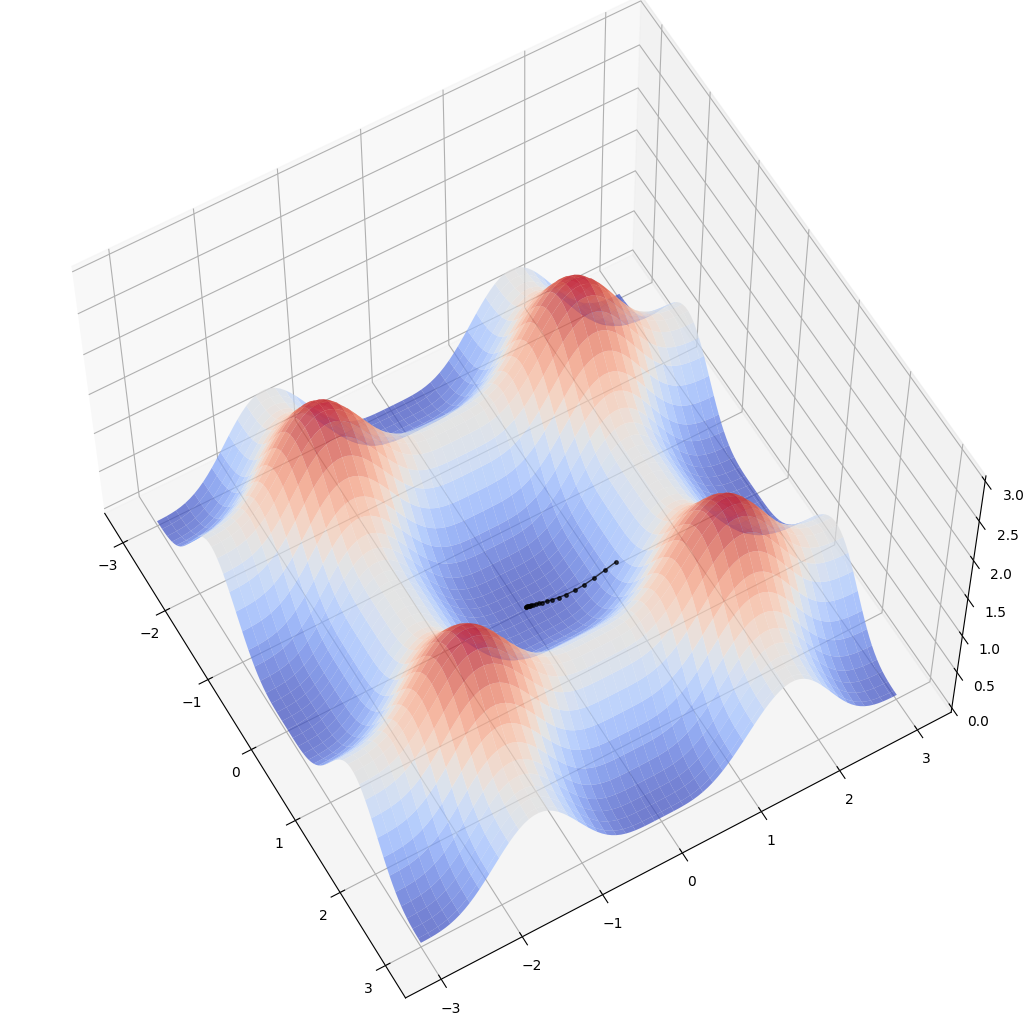

In [69]:
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm

X, Y = np.meshgrid(np.linspace(-3, 3, 100), np.linspace(-3, 3, 100))
Z = np.array([f(np.array([x,y])) for x, y in zip(np.ravel(X), np.ravel(Y))]).reshape(X.shape)

fig = plt.figure(figsize=(16, 10))
ax = Axes3D(fig)
fig.add_axes(ax)

ax.plot_surface(X, Y, Z, cmap=cm.coolwarm, alpha=0.7, zorder=2)
ax.plot(xs=steps[:, 0], ys=steps[:, 1], zs=steps[:, 2], marker='.', color='black', linewidth=1, markersize=5, zorder=3, alpha=0.7)

ax.set_zlim(0, 3)
ax.view_init(elev=60, azim=-30)
plt.show()

Посмотрим на зависимость значений функции от шага

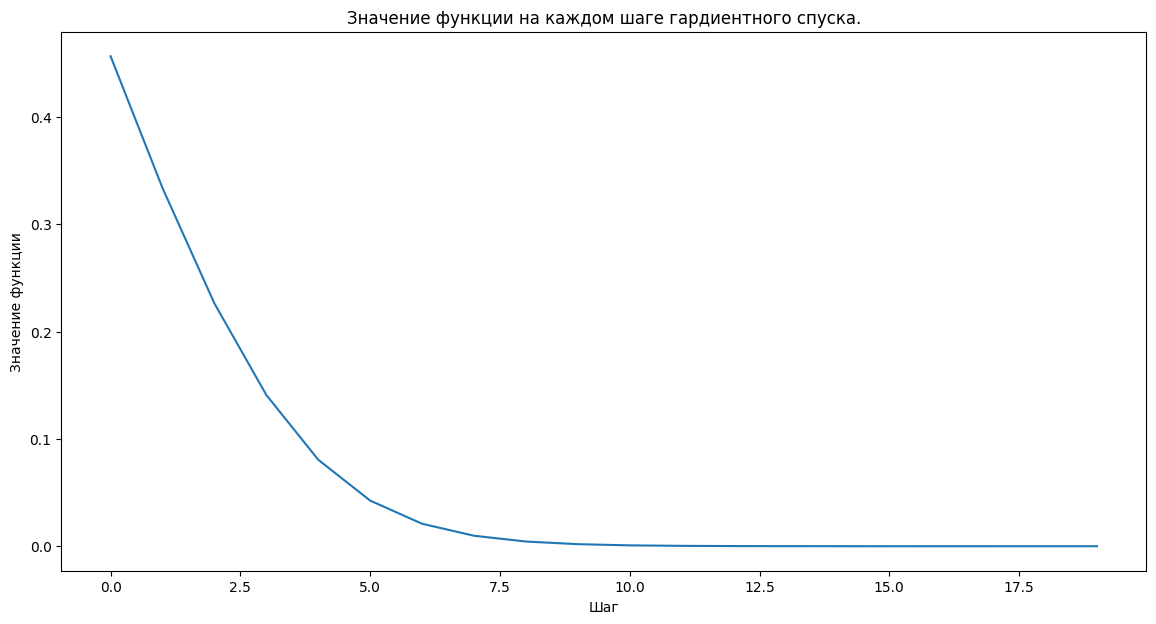

In [70]:
plt.figure(figsize=(14,7))
plt.xlabel('Шаг')
plt.ylabel('Значение функции')
plt.title('Значение функции на каждом шаге гардиентного спуска.')

plt.plot(steps[:, 2], label='gradient descent result')
plt.show()

### Генератор батчей

In [71]:
class Iterator():
    def __init__(self, X, y, batch_size):
        self.X = X
        self.y = y
        self.batch_size = batch_size
        self._current_ind = 0
    
    def __next__(self):
        if self._current_ind + self.batch_size > len(X):
            raise StopIteration
        batch = (self.X[self._current_ind : self._current_ind + self.batch_size],
                    self.y[self._current_ind : self._current_ind + self.batch_size])
        self._current_ind += self.batch_size
        return batch


class Dataset():
    def __init__(self, X, y, batch_size=None):
        self.X = X
        self.y = y
        self.batch_size = len(X) if batch_size == None else batch_size

    def __len__(self):
        return len(self.X)

    def __iter__(self):
        p = np.random.permutation(len(self))
        return Iterator(self.X[p], self.y[p], self.batch_size)

### Обычная логистическая регрессия


In [72]:
def logit(X, w):
    return np.dot(X, w)

def sigmoid(h):
    return 1. / (1 + np.exp(-h))

In [73]:
class LogisticRegression():
    def __init__(self):
        self.w = None

    def fit(self, X, y, epochs=10, lr=0.1, batch_size=100):
        l, n = X.shape
        if self.w is None:
            self.w = np.random.randn(n + 1)

        X_train = np.concatenate((np.ones((l, 1)), X), axis=1)
        losses = []
        for _ in range(epochs):
            for X_batch, y_batch in Dataset(X_train, y, batch_size):
                predictions = self._predict_proba(X_batch)
                losses.append(self._loss(y_batch, predictions))
                self.w -= lr * self.get_grad(X_batch, y_batch, predictions)

        return losses
    
    def _loss(self, y, p):
        p = np.clip(p, 1e-10, 1 - 1e-10)
        return -np.sum(y * np.log(p) + (1 - y) * np.log(1 - p))
    
    def get_grad(self, X_batch, y_batch, predictions):
        return np.dot(X_batch.T, predictions - y_batch)

    def predict_proba(self, X):
        return self._predict_proba(np.concatenate((np.ones((X.shape[0], 1)), X), axis=1))

    def _predict_proba(self, X):
        return sigmoid(logit(X, self.w))

    def predict(self, X, threshold=0.5):
        return self.predict_proba(X) >= threshold

    def get_weights(self):
        return self.w.copy()

### Логистическая регрессия с $l_1$ и $l_2$ регуляризацией


In [87]:
class ElasticLogisticRegression(LogisticRegression):
    def __init__(self, l1_coef, l2_coef):
        self.l1_coef = l1_coef
        self.l2_coef = l2_coef
        self.w = None

    def get_grad(self, X_batch, y_batch, predictions):
        grad_basic = super().get_grad(X_batch, y_batch, predictions)
        grad_l1 = np.insert(self.l1_coef * np.sign(self.w[1:]), 0, 0)
        grad_l2 = np.insert(2 * self.l2_coef * self.w[1:], 0, 0)
        return grad_basic + grad_l1 + grad_l2

### Смотрим, как работает наша модель

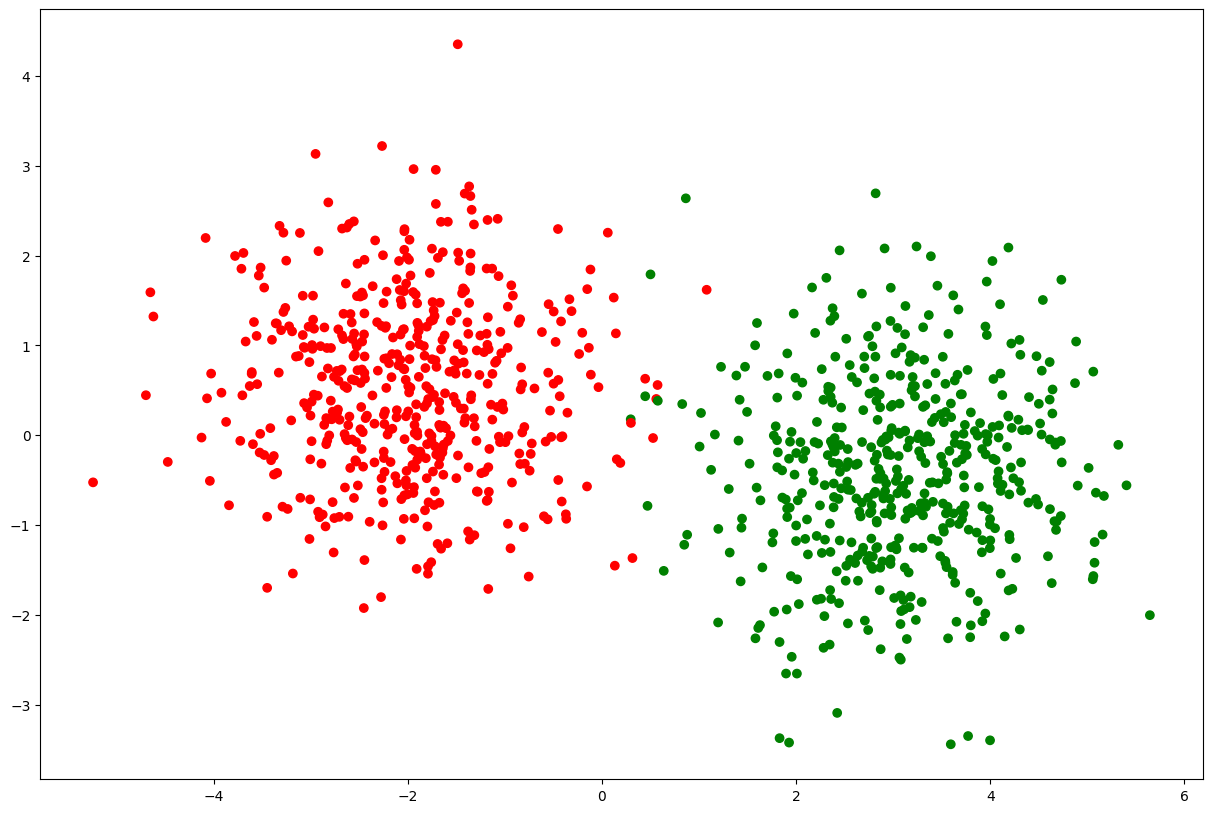

In [75]:
from sklearn.datasets import make_blobs
X, y = make_blobs(n_samples=1000, centers=[[-2,0.5],[3,-0.5]], cluster_std=1, random_state=42)

colors = ("red", "green")
colored_y = np.zeros(y.size, dtype=str)

for i, cl in enumerate([0,1]):
    colored_y[y == cl] = str(colors[i])

plt.figure(figsize=(15,10))
plt.scatter(X[:, 0], X[:, 1], c=colored_y)
plt.show()

In [76]:
clf = ElasticLogisticRegression(0.1, 0.1)
clf.fit(X, y, epochs=1000)
w = clf.get_weights()

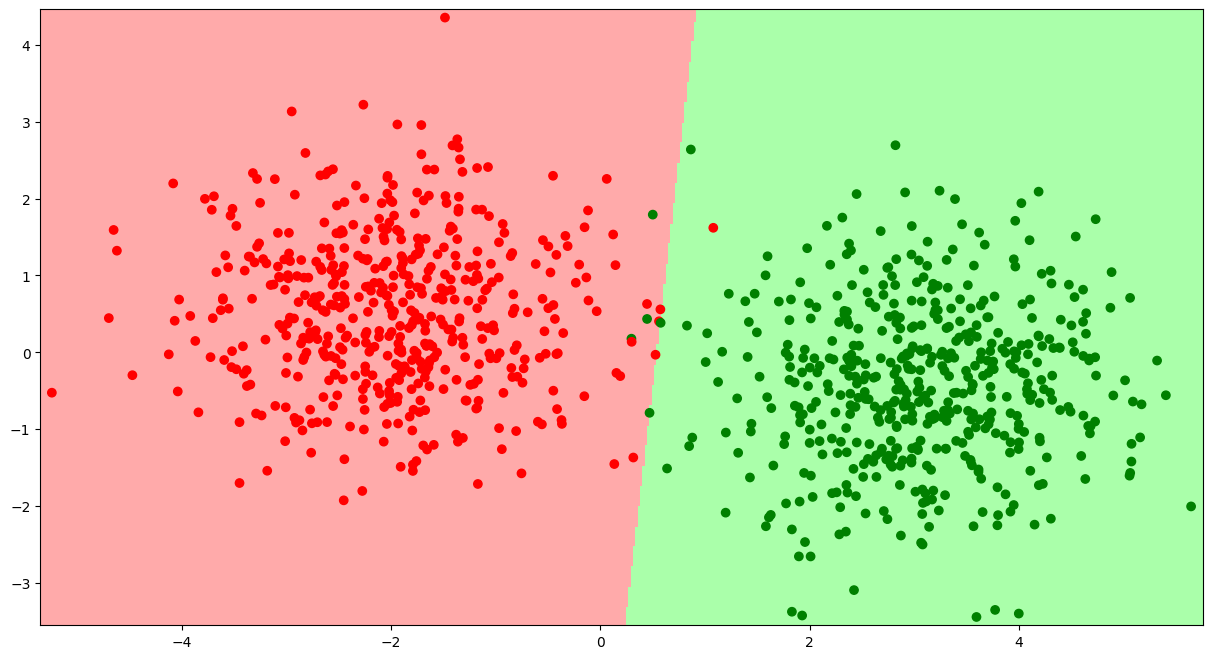

In [77]:
from matplotlib.colors import ListedColormap

plt.figure(figsize=(15,8))

eps = 0.1
xv, yv = np.meshgrid(np.linspace(np.min(X[:,0]) - eps, np.max(X[:,0]) + eps, 500),
                     np.linspace(np.min(X[:,1]) - eps, np.max(X[:,1]) + eps, 500))
z = clf.predict(np.c_[xv.ravel(), yv.ravel()]).reshape(xv.shape)

plt.pcolormesh(xv, yv, z, cmap=ListedColormap(['#FFAAAA', '#AAFFAA']))
plt.scatter(X[:, 0], X[:, 1], c=colored_y)
plt.show()

Проверим модель на датасете MNIST. Так как мы сделали классификатор для двух классов, оставим только картинки 0 и 1, и превратим их в вектора.

<img src="https://www.researchgate.net/profile/Steven_Young11/publication/306056875/figure/fig1/AS:393921575309346@1470929630835/Example-images-from-the-MNIST-dataset.png"/>

In [78]:
data = pd.read_csv('./data.csv')
data.head()

,label,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [93]:
X = data.iloc[:, 1:].to_numpy()
y = data.iloc[:, 0].to_numpy()

Для оценки модели мы используем кросс валидацию.

In [95]:
from sklearn.model_selection import cross_val_score
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler

pipeline = make_pipeline(StandardScaler(), ElasticLogisticRegression(0.1, 0.1))
mean_accuracy = cross_val_score(pipeline, X, y, scoring='accuracy').mean()

print(f"Mean accuracy of Logistic Regression for two classes is {mean_accuracy}")

C:\Users\R1300-W-6-Stud\AppData\Local\Temp\ipykernel_11628\3317507510.py:5: RuntimeWarning: overflow encountered in exp
  return 1. / (1 + np.exp(-h))
C:\Users\R1300-W-6-Stud\AppData\Local\Temp\ipykernel_11628\3317507510.py:5: RuntimeWarning: overflow encountered in exp
  return 1. / (1 + np.exp(-h))
C:\Users\R1300-W-6-Stud\AppData\Local\Temp\ipykernel_11628\3317507510.py:5: RuntimeWarning: overflow encountered in exp
  return 1. / (1 + np.exp(-h))
C:\Users\R1300-W-6-Stud\AppData\Local\Temp\ipykernel_11628\3317507510.py:5: RuntimeWarning: overflow encountered in exp
  return 1. / (1 + np.exp(-h))
C:\Users\R1300-W-6-Stud\AppData\Local\Temp\ipykernel_11628\3317507510.py:5: RuntimeWarning: overflow encountered in exp
  return 1. / (1 + np.exp(-h))


Mean accuracy of Logistic Regression for two classes is 0.9938746570664568
